**Acropora tenuis spp in the central Philippines - isolation by distance within cryptic taxa**\

_Inputs:_\
Metadata with lat/lons of sampling locations\
SNP data from each cryptic taxon in genind format\
_Outputs:_\
Fst and linearized Fst between each pair of sites\
Great circle distances between each pair of sites\
Linear regressions and Mantel tests\
Figures\
Created by Jaelyn Bos, November 2024

In [1]:
.libPaths('/hb/home/jbos/.conda/envs/vcfR')
.libPaths("/hb/home/jbos/.conda/envs/vcfR/lib/R/library")
#.libPaths('/hb/software/apps/r/conda3-4.4.1/lib/R/library')
#.libPaths('/hb/home/jbos/R/x86_64-conda-linux-gnu-library/4.4')

In [2]:
#Load required packages
library(adegenet)
library(hierfstat)
library(tidyverse)
library(vegan)
library(vcfR)
library(sp)
library(sf)
library(cowplot)

Loading required package: ade4


   /// adegenet 2.1.11 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()




Attaching package: ‘hierfstat’


The following objects are masked from ‘package:adegenet’:

    Hs, read.fstat


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-8


   *****       ***   vcfR   ***       *****
   This is vcfR 1

In [3]:
#Input: site string
#Output: island tag
island_sel <- function(string){
  x<-substr(string, start = 1, stop = 3)
  return(x)
}

In [4]:
#Inputs: wide form FSTs and dataframe of individuals corresponding to each population
#Output: long form FSTs. Columns: siteA	siteB	fst	siteA_counts	siteB_counts	mean_counts
fst_transform<-function(fsts,indpops){
    fst_long<-pivot_longer(fsts,cols=colnames(fsts)[2:length(colnames(fsts))],names_to='siteB',values_to='fst')
    colnames(fst_long)<-c('siteA','siteB','fst')
    fst_long<-fst_long[!is.nan(fst_long$fst),]
    dum<-as.data.frame(table(indpops$Population))
    colnames(dum)<-c('siteA','siteA_counts')
    fst_long<-left_join(fst_long,dum,by='siteA')
    colnames(dum)<-c('siteB','siteB_counts')
    fst_long<-left_join(fst_long,dum,by='siteB')
    fst_long$mean_counts<-rowMeans(as.data.frame(cbind(fst_long$siteA_counts,fst_long$siteB_counts)))
    return(fst_long)
}

In [5]:
#Input: FSTs, vector of number of individuals per population, minimum number of individuals per popualtion
#Output: Matrix of FSTs including only populations above the minimum size
fst_trim_by_N<-function(fsts,inds_per_pop,min_n){
    fsts<-as.data.frame(fsts)
    fst_trim<-fsts[fsts$...1 %in% as.data.frame(table(inds_per_pop$Population)[table(inds_per_pop$Population)>(min_n-1)])$Var1,]
    fst_trim<-fst_trim[,colnames(fst_trim)%in% as.data.frame(table(inds_per_pop$Population)[table(inds_per_pop$Population)>(min_n-1)])$Var1]
    rownames(fst_trim)<-colnames(fst_trim)
    return(fst_trim)
    }

In [6]:
#Inputs: wide form FSTs
#Outputs: wide form linearized FSTs for Mantel test
linear_fsts<-function(wide_fsts){
  wide_fsts<-as.data.frame(wide_fsts)
  rownames(wide_fsts)<-wide_fsts$...1
  wide_fsts<-wide_fsts[,-1]
  fst_lin <- wide_fsts/(1-wide_fsts)
  return(fst_lin)
}

linear_fsts2<-function(wide_fsts){
  wide_fsts<-as.data.frame(wide_fsts)
  fst_lin <- wide_fsts/(1-wide_fsts)
  return(fst_lin)
}

In [7]:
#Creates appropriate row names for site distance matrix: this is important for running Mantel tests
rnam<-function(d){
    rownames(d)<-d$X
    d<-d[,-1]
    return(d)
    }

In [8]:
#Inputs: wide form linearized FSTs and wide form distances for each cryptic taxon
#Outputs: long form dataframe with columns SiteA	SiteB	Lin_FST	Distance_m
fst_dist_join<-function(fsts_linear, distances){
    fsts_linear$SiteA<-rownames(fsts_linear)
    distances$SiteA<-rownames(distances)
    fst_lin_lon<-pivot_longer(data=fsts_linear,cols=colnames(fsts_linear)[!(colnames(fsts_linear) %in% 'SiteA')],names_to='SiteB',values_to='Lin_FST')
    dists_lon<-pivot_longer(data=distances,cols=colnames(distances)[!(colnames(distances) %in% 'SiteA')],names_to='SiteB',values_to='Distance_m')
    mer<-inner_join(fst_lin_lon,dists_lon)
    mer<-mer[mer$SiteA!=mer$SiteB,]
    mer$Distance_m<-as.numeric(mer$Distance_m)
    mer_uniquerows <- mer %>% distinct(Distance_m, .keep_all = TRUE)
    return(mer_uniquerows)
    }

In [9]:
#Input: long form data with both pairwise FST and pairwise distance
#Output: long form data with both pairwise FST and pairwise distance for Cebu only
Ceb_merge<-function(mer){
    mer$IslandA<-island_sel(mer$SiteA)
    mer$IslandB<-island_sel(mer$SiteB)
    Ceb<-mer[mer$IslandA=='CEB' & mer$IslandB=='CEB',]
    Ceb<-Ceb[,-c(5,6)] #Drop stupid columns that just say 'CEB'
    return(Ceb)
    }

In [10]:
findChiSqCIs_LAZY <- function(De, Del95, Deu95){
  test_dfs<-seq(1,3000,by=1)
  y<-vector()
  z<-vector()
  for (i in 1:length(test_dfs)){
    y[i]<-mean(c(Del95, Deu95)*qchisq(c(0.975, 0.025), df=test_dfs[i])/De)
    z[i]<-abs(y[i]-test_dfs[i])
  }
  return(test_dfs[z==min(z)])
}


In [11]:
#Calculate 1000 bootstrap replicates of estimated population densities from NeEstimator outputs
DeFromNb <- function(niter, AL, alpha, Waples_Nb, Waples_Nbl95, Waples_Nbu95, A){
    #Fit the Waples et al. model to relate log10(AL/alpha) to the Nb/Ne ratio
	dat = read.csv('AllSpecies4_trim.csv') # data from Waples et al. 2013 PRSB
	mod = lm(NbNe ~ logRLAM, data=dat) # fit model

	#Get CIs and samples for our Nb/Ne ratio (using AL and alpha)
	NbNe = predict(mod, new=data.frame(logRLAM = log10(AL/alpha)), interval='prediction', level=0.95) # get the 95%CI prediction intervals
	a = c(NbNe[,1] - NbNe[,2], NbNe[,3] - NbNe[,1]) # the CI intervals
	NbNes1 = rnorm(niter, mean = NbNe[,1], sd = mean(a)/1.96) # generate first set of Nb/Ne samples
	NbNes2 = rnorm(niter, mean = NbNe[,1], sd = mean(a)/1.96) # generate second set (need two draws since used 2x in equation)

	# generate point values for De
	Waples_Nb_adj = Waples_Nb/(1.26-0.323*NbNe[,1]) # point estimate for Nb after correction. From Waples et al. 2014 Genetics. We use the equation for "True Nb/Ne" from Table 3 because we have estimated Nb/Ne as a probability distribution (the "Using two traits" version in Table 3 is nothing more than inserting Nb/Ne=0.485+0.758log(AL/alpha) into Eq. 8). 
	Waples_Ne_adj = Waples_Nb_adj/NbNe[,1] # point estimate for Ne after correction. From Eq. Waples et al. 2014. We used the equation for "True Nb/Ne" from Table 3 because we have estimated Nb/Ne as a probability distribution.
	De <- Waples_Ne_adj/A # the point estimate for De

	# generate samples from Nb
	a2 <- findChiSqCIs_LAZY(Waples_Nb, Waples_Nbl95, Waples_Nbu95) # find the degrees of freedom for a chi-squared distribution that fits our upper and lower 95% CI values
	WaplesNbs = a2*Waples_Nb/rchisq(niter, df=a2) # generate Nb values from chisq distribution (unadjusted Nb)

	# optional debugging to check fitting of the chi-squared distribution
	# print(paste('a2=', a2, 'for i=',i))
	# print(rbind(signif(quantile(WaplesNbs, c(0.025, 0.975)),4), signif(Waples_Nbl95, Waples_Nbu95))) # second line values should be close to values in first line

	# convert range of Nbs to range of Nes and Des using Waples et al. 2013 PRSB equations
	Nbs_adj = WaplesNbs/(1.26-0.323*NbNes1)
	Nes_adj = Nbs_adj/NbNes2
	Des <- Nes_adj/A # and for De
#	Del95 = quantile(Des, 0.025)
#	Deu95 = quantile(Des, 0.975)

	return(list(De=De, Des=Des))
}

In [12]:
# Calculate sigma (dispersal kernel spread) from number of breeders (Nb)
# Uses Waples et al. 2013 PRSB/Waples et al. 2014 Genetics correction for Nb to Ne
#
# niter: number of iterations to produce
# AL: adult lifespan (years)
# alpha: minimum age of maturity (years)
# Waples_Nb: linkage disequilibrium estimate of the number of breeders (e.g., output from NeEstimator based on a single cohort)
# Waples_Nbl95: lower 95% confidence interval for Waples_Nb
# Waples_Nbu95: upper 95% confidence interval for Waples_Nb
# A: length (1D) or area (2D) of the region to which the Nb estimate applies
#Note that densities are in individuals/m, therefore sigma is also in meters
sigmaFrom_m <- function(De, Des=rep(De,1000), m, mse, dims=1){
	niter <- length(Des)
	# generate range of slope estimates
	ms = rnorm(niter, mean = m, sd = mse)
	# calculate sigma
	if(dims==1){
		sigma_point <- sqrt(1/(4*De*m)) # the point estimate for 1D
		sigmas = sqrt(1/(4*Des*ms)) # the range of estimates for 1D
	}
	if(dims==2){
		sigma_point = sqrt(1/(4*pi*De*m)) # the point estimate for 2D
		sigmas = sqrt(1/(4*pi*Des*ms)) # the range of estimates for 2D
	}
	if(!(dims %in% c(1,2))){
		stop('Dimensions need to be 1 or 2')
	}
	return(list(sigma_point=sigma_point, sigmas=sigmas))
}

In [13]:
#Calculate great circle distances from lat/lons
wide_dists <- function(sites){
    x<-st_as_sf(sites,coords=c('LONGITUDE','LATITUDE'))
    x<-st_set_crs(x,4326)
    d <- st_distance(x)
    colnames(d)<-sites$Name
    rownames(d)<-sites$Name
    d<-as.data.frame(d)
    return(d)
}

In [14]:
#Stick together datasets for figure making
join_for_fig<-function(merged_data,long_fsts){
    merged_data$SiteAB<-paste(merged_data$SiteA,merged_data$SiteB)
    long_fsts$SiteAB<-paste(long_fsts$siteA,long_fsts$siteB)
    new<-left_join(merged_data,long_fsts,by='SiteAB')
    new$Distance_km<-new$Distance_m/1000
    new<-new[,c('SiteA','SiteB','Lin_FST','Distance_m','mean_counts','Distance_km')]
    }

In [15]:
#Import site locations with lat/lons
sites <- read.csv("all_Atenuis_sites_FIXED.csv")

Import data in vcf form. VCFs are filtered SNPs for each cryptic taxon

In [16]:
#Import VCF for each cryptic species
setwd('/hb/scratch/jbos/')
spp1<-read.vcfR("spp1/vcf_thinned500bp.recode.vcf")
spp2<-read.vcfR("spp2/vcf_thinned500bp.recode.vcf")
spp3<-read.vcfR("spp3/vcf_thinned500bp.recode.vcf")
spp4<-read.vcfR("spp4/vcf_thinned500bp.recode.vcf")
spp0<-read.vcfR("combined_snps/vcf_thinned500bp.recode.vcf")

Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 606
  column count: 133
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 606
  Character matrix gt cols: 133
  skip: 0
  nrows: 606
  row_num: 0
Processed variant: 606
All variants processed
Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 640
  column count: 82
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 640
  Character matrix gt cols: 82
  skip: 0
  nrows: 640
  row_num: 0
Processed variant: 640
All variants processed
Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 798
  column count: 69
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt create

In [21]:
#Convert VCF files to genind
genind1 <- vcfR2genind(spp1)
genind2 <- vcfR2genind(spp2)
genind3 <- vcfR2genind(spp3)
genind4 <- vcfR2genind(spp4)
genind0 <- vcfR2genind(spp0)

In [22]:
#Get lists of individuals for each cryptic taxon
taxa1_inds<-rownames(genind1@tab)
taxa2_inds<-rownames(genind2@tab)
taxa3_inds<-rownames(genind3@tab)
taxa4_inds<-rownames(genind4@tab)
taxa0_inds<-rownames(genind0@tab)

In [25]:
#Write lists of individuals in each cryptic taxon to CSV
setwd('/hb/home/jbos/')

write.csv(taxa1_inds,'taxa1_inds.csv')
write.csv(taxa2_inds,'taxa2_inds.csv')
write.csv(taxa3_inds,'taxa3_inds.csv')
write.csv(taxa4_inds,'taxa4_inds.csv')

In [26]:
#Create individual lat/lons (by sampling site) dataset with variable for taxon
ind_latlons<-as.data.frame(taxa0_inds)
colnames(ind_latlons)<-'sample_ID'
ind_latlons$Name<-unlist(lapply(strsplit(ind_latlons$sample_ID,"_"), head, 1))
ind_latlons<-left_join(ind_latlons,sites)

ind_latlons$taxa<-0
ind_latlons$taxa[ind_latlons$sample_ID %in% taxa1_inds]<-1
ind_latlons$taxa[ind_latlons$sample_ID %in% taxa2_inds]<-2
ind_latlons$taxa[ind_latlons$sample_ID %in% taxa3_inds]<-3
ind_latlons$taxa[ind_latlons$sample_ID %in% taxa4_inds]<-4

Joining with `by = join_by(Name)`


In [27]:
#Median latitude by taxon
median(ind_latlons$LATITUDE[ind_latlons$taxa==1])
median(ind_latlons$LATITUDE[ind_latlons$taxa==2])
median(ind_latlons$LATITUDE[ind_latlons$taxa==3])
median(ind_latlons$LATITUDE[ind_latlons$taxa==4])

[1] 10.50607

[1] 10.50607

[1] 10.2396

[1] 9.966725

In [28]:
#Kruskal Wallis test for latitude by group
kruskal.test(LATITUDE ~ taxa, data = ind_latlons)


	Kruskal-Wallis rank sum test

data:  LATITUDE by taxa
Kruskal-Wallis chi-squared = 28.03, df = 4, p-value = 1.23e-05


In [29]:
#Add population factors to each genind. Here, we define a sampling site as a population
genind1@pop <-as.factor(unlist(lapply(strsplit(rownames(genind1$tab),"_"), head, 1)))
genind2@pop <-as.factor(unlist(lapply(strsplit(rownames(genind2$tab),"_"), head, 1)))
genind3@pop <-as.factor(unlist(lapply(strsplit(rownames(genind3$tab),"_"), head, 1)))
genind4@pop <-as.factor(unlist(lapply(strsplit(rownames(genind4$tab),"_"), head, 1)))
genind0@pop <-as.factor(unlist(lapply(strsplit(rownames(genind0$tab),"_"), head, 1)))

In [30]:
sites1<-sites[sites$Name %in% unique(genind1@pop),]
sites2<-sites[sites$Name %in% unique(genind2@pop),]
sites3<-sites[sites$Name %in% unique(genind3@pop),]
sites4<-sites[sites$Name %in% unique(genind4@pop),]
sites0<-sites[sites$Name %in% unique(genind0@pop),]

In [31]:
#Convert genind to hierfstat form to calculate FSTs
hstat1<-genind2hierfstat(genind1,pop=genind1@pop)
hstat2<-genind2hierfstat(genind2,pop=genind2@pop)
hstat3<-genind2hierfstat(genind3,pop=genind3@pop)
hstat4<-genind2hierfstat(genind4,pop=genind4@pop)
hstat0<-genind2hierfstat(genind0,pop=genind0@pop)

In [32]:
#Make wide form dataframes of distance between sites
dists1<-wide_dists(sites1)
dists2<-wide_dists(sites2)
dists3<-wide_dists(sites3)
dists4<-wide_dists(sites4)
dists0<-wide_dists(sites0)

In [33]:
#Take log of distances for Mantel tests
log_dists1<-log(dists1)
log_dists2<-log(dists2)
log_dists3<-log(dists3)
log_dists4<-log(dists4)
log_dists0<-log(dists0)

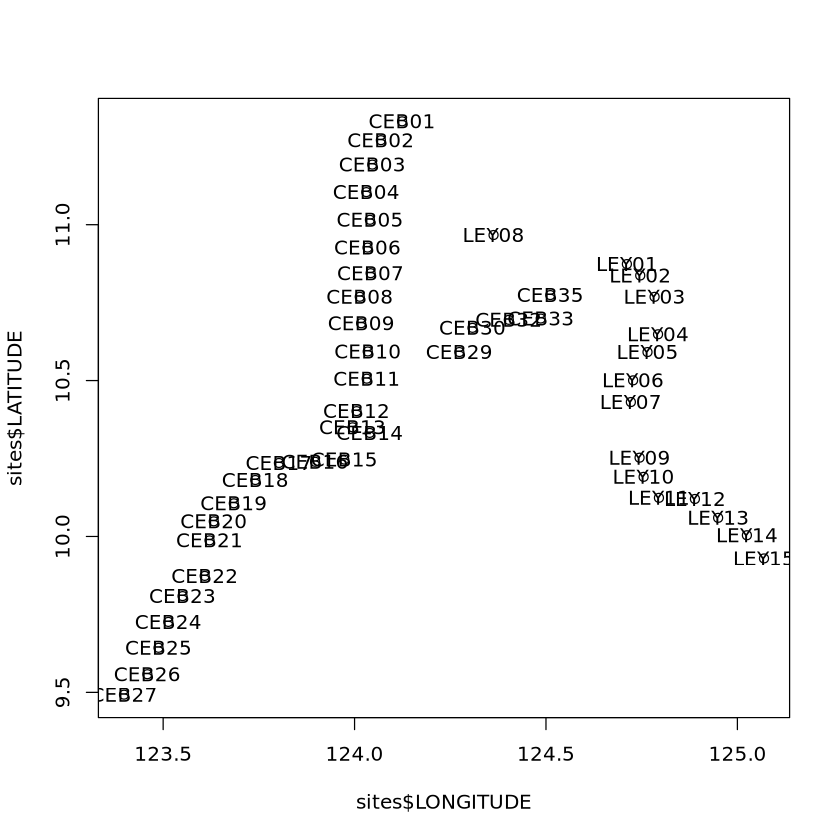

In [34]:
#Plot site names by lat/lon as a sanity check
plot(sites$LONGITUDE, sites$LATITUDE,text(sites$LONGITUDE, sites$LATITUDE,sites$Name))

In [35]:
#Make sf object out of points(this will be useful later)
sites_sf<-st_as_sf(sites,coords=c('LONGITUDE','LATITUDE'))
sites_sf<-st_set_crs(sites_sf,4326)
sitepoints<-st_combine(sites_sf)
sites_proj<-st_transform(sitepoints,crs=9834)

Calculate pairwise FSTs with confidence intervals within each cryptic taxon

In [24]:
#fst_1<-pairwise.WCfst(hstat1)
#fst_2<-pairwise.WCfst(hstat2)
#fst_3<-pairwise.WCfst(hstat3)
#fst_4<-pairwise.WCfst(hstat4)
#fst_all<-pairwise.WCfst(hstat0)

In [25]:
#Write pairwise FSTs to FST
#write.csv(fst_1,'fst_1_500bp.csv',row.names=TRUE)
#write.csv(fst_2,'fst_2_500bp.csv',row.names=TRUE)
#write.csv(fst_3,'fst_3_500bp.csv',row.names=TRUE)
#write.csv(fst_4,'fst_4_500bp.csv',row.names=TRUE)
#write.csv(fst_all,'fst_all_500bp.csv',row.names=TRUE)

In [36]:
#Alternatively, read in pairwise FSTs from csv
fst1<-read_csv('fst_1_500bp.csv',show_col_types = FALSE)
fst2<-read_csv('fst_2_500bp.csv',show_col_types = FALSE)
fst3<-read_csv('fst_3_500bp.csv',show_col_types = FALSE)
fst4<-read_csv('fst_4_500bp.csv',show_col_types = FALSE)
fstall<-read_csv('fst_all_500bp.csv',show_col_types = FALSE)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


In [37]:
#Make dataframes of individuals and corresponding populations for each taxon
inds_per_pop1<-as.data.frame(cbind(rownames(genind1@tab),as.character(genind1@pop)))
colnames(inds_per_pop1)<-c("Individual","Population")

inds_per_pop2<-as.data.frame(cbind(rownames(genind2@tab),as.character(genind2@pop)))
colnames(inds_per_pop2)<-c("Individual","Population")

inds_per_pop3<-as.data.frame(cbind(rownames(genind3@tab),as.character(genind3@pop)))
colnames(inds_per_pop3)<-c("Individual","Population")

inds_per_pop4<-as.data.frame(cbind(rownames(genind4@tab),as.character(genind4@pop)))
colnames(inds_per_pop4)<-c("Individual","Population")

inds_per_pop0<-as.data.frame(cbind(rownames(genind0@tab),as.character(genind0@pop)))
colnames(inds_per_pop0)<-c("Individual","Population")

In [38]:
#Transform FSTs to long form and add variables for number of individuals in each population
fst1_long<-fst_transform(fst1,inds_per_pop1)
fst2_long<-fst_transform(fst2,inds_per_pop2)
fst3_long<-fst_transform(fst3,inds_per_pop3)
fst4_long<-fst_transform(fst4,inds_per_pop4)
fst0_long<-fst_transform(fstall,inds_per_pop0)

In [39]:
#Make FST set without the three weird taxa 3 individuals
fst3_long_special<-fst3_long[!(fst3_long$siteA %in% c('CEB01','CEB23')),]
fst3_long_special<-fst3_long_special[!(fst3_long_special$siteB %in% c('CEB01','CEB23')),]

Plot pairwise FSTs vs. individuals/site. This is a nice check to see if high FSTs are mostly or purely due to having few individuals per site

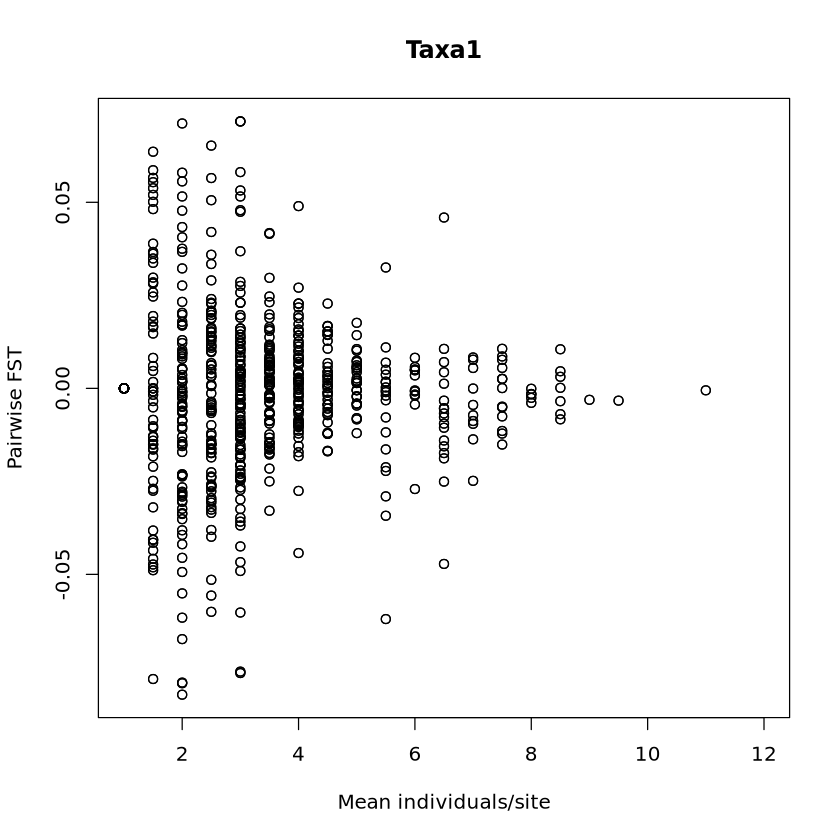

In [35]:
plot(fst1_long$mean_counts,fst1_long$fst,main="Taxa1",xlab="Mean individuals/site",ylab="Pairwise FST")

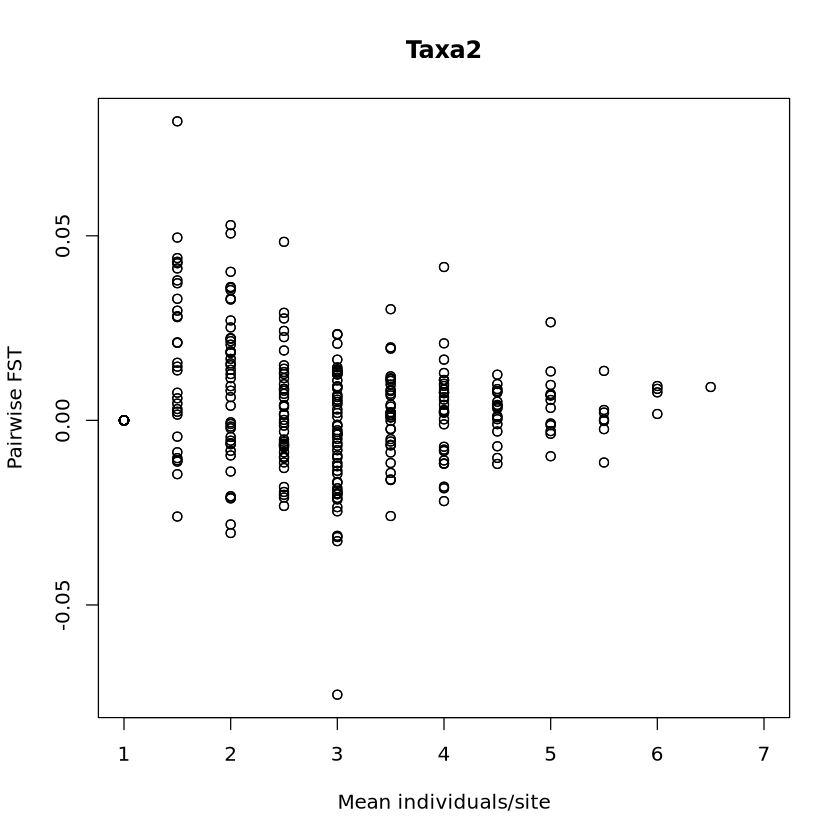

In [36]:
plot(fst2_long$mean_counts,fst2_long$fst,main="Taxa2",xlab="Mean individuals/site",ylab="Pairwise FST")

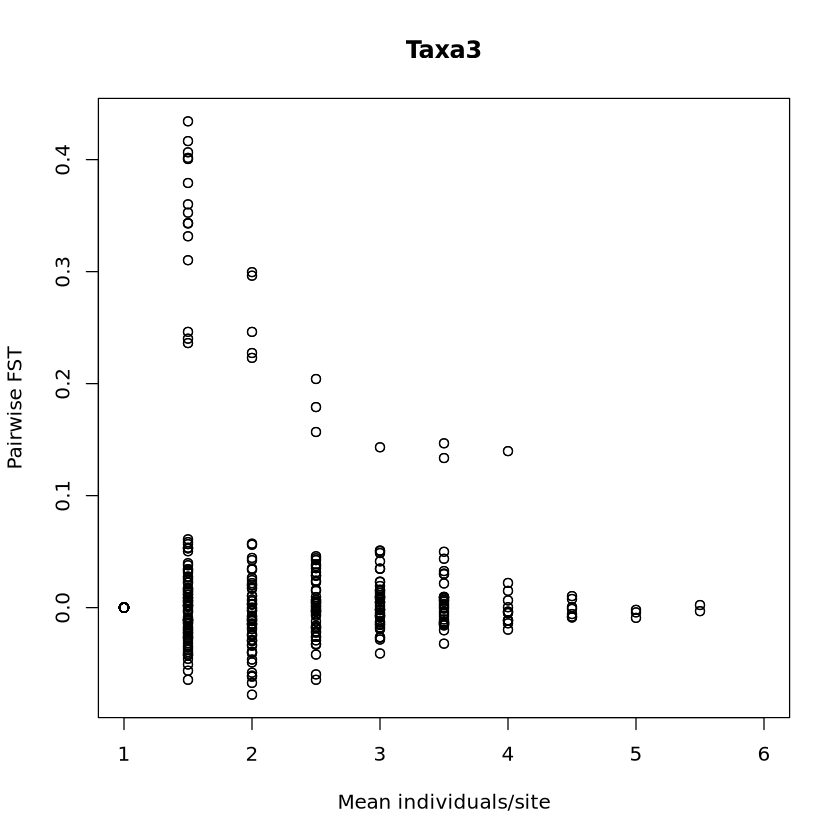

In [37]:
plot(fst3_long$mean_counts,fst3_long$fst,main="Taxa3",xlab="Mean individuals/site",ylab="Pairwise FST")

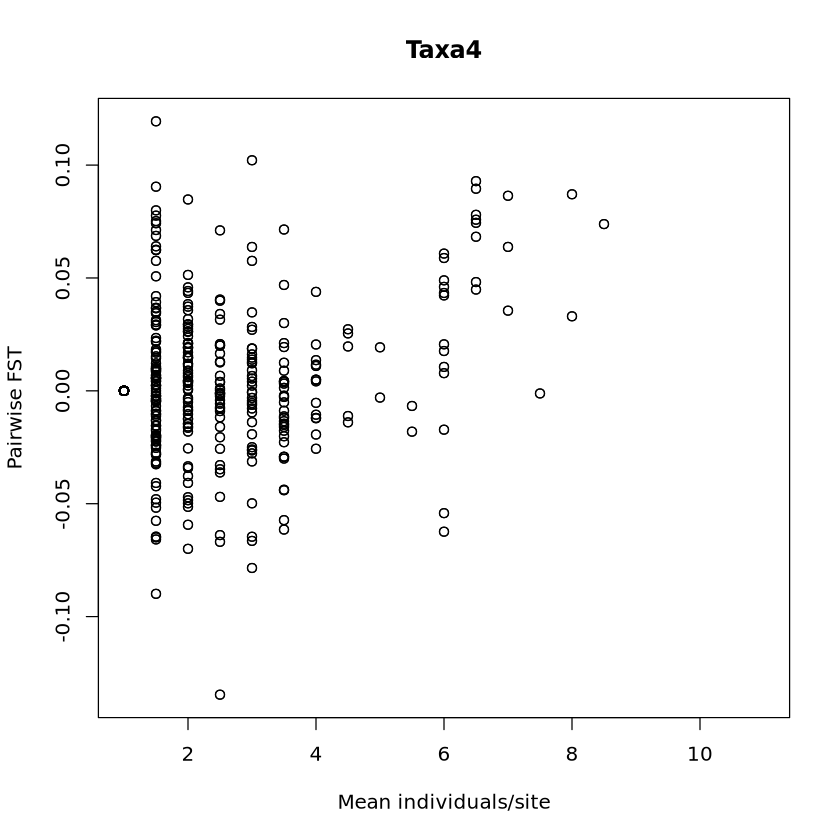

In [38]:
plot(fst4_long$mean_counts,fst4_long$fst,main="Taxa4",xlab="Mean individuals/site",ylab="Pairwise FST")

In [40]:
#Create matrix of FSTs only including populations where N>=3
fst_trim1<-fst_trim_by_N(fst1,inds_per_pop1,3)
fst_trim2<-fst_trim_by_N(fst2,inds_per_pop2,3)
fst_trim3<-fst_trim_by_N(fst3,inds_per_pop3,3)
fst_trim4<-fst_trim_by_N(fst4,inds_per_pop4,3)
fst_trim0<-fst_trim_by_N(fstall,inds_per_pop0,3)

In [41]:
#Create matrices of pairwise distances to correspond to sites with sufficiently high FSTs.
dists_trim1<-dists1[rownames(dists1) %in% colnames(fst_trim1),colnames(dists1) %in% colnames(fst_trim1)]
dists_trim2<-dists2[rownames(dists2) %in% colnames(fst_trim2),colnames(dists2) %in% colnames(fst_trim2)]
dists_trim3<-dists3[rownames(dists3) %in% colnames(fst_trim3),colnames(dists3) %in% colnames(fst_trim3)]
dists_trim4<-dists4[rownames(dists4) %in% colnames(fst_trim4),colnames(dists4) %in% colnames(fst_trim4)]
dists_trim0<-dists0[rownames(dists0) %in% colnames(fst_trim0),colnames(dists0) %in% colnames(fst_trim0)]

In [42]:
#Convert wide form FSTs to linearized wide form FSTs for use in Mantel test
fst_lin1<-as.data.frame(linear_fsts(fst1))
fst_lin2<-as.data.frame(linear_fsts(fst2))
fst_lin3<-as.data.frame(linear_fsts(fst3))
fst_lin4<-as.data.frame(linear_fsts(fst4))
fst_lin0<-as.data.frame(linear_fsts(fstall))

In [43]:
#Convert wide form FSTs to linearized wide form FSTs for use in Mantel test, excluding low N sites
fst_lin1_trim<-as.data.frame(linear_fsts(fst_trim1))
fst_lin2_trim<-as.data.frame(linear_fsts(fst_trim2))
fst_lin3_trim<-as.data.frame(linear_fsts(fst_trim3))
fst_lin4_trim<-as.data.frame(linear_fsts(fst_trim4))
fst_lin0_trim<-as.data.frame(linear_fsts(fst_trim0))

In [45]:
#Create matrices for Taxa 3 with inbred individuals excluded
fst_lin3_special<-fst_lin3[!(rownames(fst_lin3) %in% c('CEB01','CEB23')), !(colnames(fst_lin3) %in% c('CEB01','CEB23'))]
dists3_special<-dists3[!(rownames(dists3) %in% c('CEB01','CEB23')), !(colnames(dists3) %in% c('CEB01','CEB23'))]

In [46]:
#Create dataframe of sites on Cebu island (exluding Camotes, which were originally labeled as Cebu)
Ceb_real <- sites[sites$LONGITUDE<124.25,3]

In [47]:
#Create matrices of FSTs from Cebu only
fst_Cebu1<-fst_lin1[rownames(fst_lin1) %in% Ceb_real, colnames(fst_lin1) %in% Ceb_real]
fst_Cebu2<-fst_lin2[rownames(fst_lin2) %in% Ceb_real, colnames(fst_lin2) %in% Ceb_real]
fst_Cebu3<-fst_lin3[rownames(fst_lin3) %in% Ceb_real, colnames(fst_lin3) %in% Ceb_real]
fst_Cebu4<-fst_lin4[rownames(fst_lin4) %in% Ceb_real, colnames(fst_lin4) %in% Ceb_real]
fst_Cebu0<-fst_lin0[rownames(fst_lin0) %in% Ceb_real, colnames(fst_lin0) %in% Ceb_real]

In [48]:
#Create matrices of pairwise distances from Cebu only
dists_Cebu1<-dists1[rownames(dists1) %in% Ceb_real, colnames(dists1) %in% Ceb_real]
dists_Cebu2<-dists2[rownames(dists2) %in% Ceb_real, colnames(dists2) %in% Ceb_real]
dists_Cebu3<-dists3[rownames(dists3) %in% Ceb_real, colnames(dists3) %in% Ceb_real]
dists_Cebu4<-dists4[rownames(dists4) %in% Ceb_real, colnames(dists4) %in% Ceb_real]
dists_Cebu0<-dists0[rownames(dists0) %in% Ceb_real, colnames(dists0) %in% Ceb_real]

Run Mantel tests for each cryptic taxon. Note that these are Mantel tests for both Cebu and Leyte together!

In [49]:
#Mantel test, taxa 1
mantel(fst_lin1,log_dists1)
mantel(fst_Cebu1,dists_Cebu1)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin1, ydis = log_dists1) 

Mantel statistic r: 0.0625 
      Significance: 0.126 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0696 0.0887 0.1041 0.1256 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_Cebu1, ydis = dists_Cebu1) 

Mantel statistic r: 0.1708 
      Significance: 0.027 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.111 0.148 0.172 0.203 
Permutation: free
Number of permutations: 999


In [90]:
#Mantel tests, taxa 2
mantel(fst_lin2,log_dists2)
mantel(fst_Cebu2,dists_Cebu2)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin2, ydis = log_dists2) 

Mantel statistic r: -0.08432 
      Significance: 0.925 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0716 0.0912 0.1124 0.1262 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_Cebu2, ydis = dists_Cebu2) 

Mantel statistic r: -0.1186 
      Significance: 0.904 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.119 0.152 0.188 0.221 
Permutation: free
Number of permutations: 999


In [88]:
#Mantel tests, taxa 3
mantel(fst_lin3,log_dists3)
mantel(fst_Cebu3,dists_Cebu3)
mantel(fst_lin3_special,dists3_special)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin3, ydis = log_dists3) 

Mantel statistic r: 0.08381 
      Significance: 0.167 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.105 0.123 0.136 0.150 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_Cebu3, ydis = dists_Cebu3) 

Mantel statistic r: 0.1716 
      Significance: 0.096 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.169 0.211 0.229 0.255 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin3_special, ydis = dists3_special) 

Mantel statistic r: -0.06184 
      Significance: 0.756 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.104 0.135 0.166 0.194 
Permutation: free
Number of permutations: 999


In [91]:
#Mantel tests, taxa 4
mantel(fst_lin4,log_dists4)
mantel(fst_Cebu4,dists_Cebu4)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin4, ydis = log_dists4) 

Mantel statistic r: 0.001583 
      Significance: 0.456 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0640 0.0816 0.1011 0.1194 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_Cebu4, ydis = dists_Cebu4) 

Mantel statistic r: 0.01568 
      Significance: 0.365 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.117 0.162 0.214 0.248 
Permutation: free
Number of permutations: 999


In [92]:
#Mantel test, all taxa together
mantel(fst_lin0,dists0)
mantel(fst_lin0,log_dists0)
mantel(fst_Cebu0,dists_Cebu0)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin0, ydis = dists0) 

Mantel statistic r: 0.06093 
      Significance: 0.184 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0954 0.1228 0.1533 0.1876 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin0, ydis = log_dists0) 

Mantel statistic r: 0.06452 
      Significance: 0.104 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0658 0.0859 0.1087 0.1298 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_Cebu0, ydis = dists_Cebu0) 

Mantel statistic r: 0.06046 
      Significance: 0.231 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.119 0.149 0.182 0.220 
Permutation: free
Number of permutations: 999


In [50]:
#Merge wide form linearized FSTs and wide form distances to long form dataframes of linearized FSTs and pairwise distances
merge1<-fst_dist_join(fst_lin1,dists1)
merge2<-fst_dist_join(fst_lin2,dists2)
merge3<-fst_dist_join(fst_lin3,dists3)
merge4<-fst_dist_join(fst_lin4,dists4)
merge0<-fst_dist_join(fst_lin0,dists0)

merge3_special<-fst_dist_join(fst_lin3_special,dists3_special)

Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`


In [52]:
#Create datasets with Cebu only
merge1_Ceb<-fst_dist_join(fst_Cebu1,dists_Cebu1)
merge2_Ceb<-fst_dist_join(fst_Cebu2,dists_Cebu2)
merge3_Ceb<-fst_dist_join(fst_Cebu3,dists_Cebu3)
merge4_Ceb<-fst_dist_join(fst_Cebu4,dists_Cebu4)

merge0_Ceb<-fst_dist_join(fst_Cebu0,dists_Cebu0)

Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`


In [53]:
colnames(merge0)

[1] "SiteA"      "SiteB"      "Lin_FST"    "Distance_m"

In [54]:
summary(lm(Lin_FST ~ log(Distance_m),data=merge0))
summary(lm(Lin_FST ~ Distance_m,data=merge0_Ceb))


Call:
lm(formula = Lin_FST ~ log(Distance_m), data = merge0)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.117273 -0.020498 -0.006418  0.015941  0.229501 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)     -0.020818   0.019858  -1.048   0.2947  
log(Distance_m)  0.003426   0.001766   1.941   0.0526 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03862 on 901 degrees of freedom
Multiple R-squared:  0.004162,	Adjusted R-squared:  0.003057 
F-statistic: 3.766 on 1 and 901 DF,  p-value: 0.05262



Call:
lm(formula = Lin_FST ~ Distance_m, data = merge0_Ceb)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.065199 -0.022590 -0.008118  0.011583  0.223383 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.018e-02  3.502e-03   5.764 1.92e-08 ***
Distance_m  4.061e-08  3.731e-08   1.089    0.277    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03433 on 323 degrees of freedom
Multiple R-squared:  0.003655,	Adjusted R-squared:  0.0005705 
F-statistic: 1.185 on 1 and 323 DF,  p-value: 0.2772


In [55]:
summary(lm(Lin_FST ~ log(Distance_m),data=merge1))
summary(lm(Lin_FST ~ log(Distance_m),data=merge2))
summary(lm(Lin_FST ~ log(Distance_m),data=merge3))
summary(lm(Lin_FST ~ log(Distance_m),data=merge4))


Call:
lm(formula = Lin_FST ~ log(Distance_m), data = merge1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.075374 -0.010821  0.000285  0.009154  0.078669 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)     -0.021931   0.013058  -1.680   0.0935 .
log(Distance_m)  0.001873   0.001161   1.614   0.1071  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02175 on 664 degrees of freedom
Multiple R-squared:  0.003906,	Adjusted R-squared:  0.002406 
F-statistic: 2.604 on 1 and 664 DF,  p-value: 0.1071



Call:
lm(formula = Lin_FST ~ log(Distance_m), data = merge2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.071661 -0.008493 -0.002361  0.007199  0.085511 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)      0.023436   0.013092   1.790   0.0744 .
log(Distance_m) -0.001758   0.001156  -1.521   0.1293  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01634 on 323 degrees of freedom
Multiple R-squared:  0.007109,	Adjusted R-squared:  0.004035 
F-statistic: 2.313 on 1 and 323 DF,  p-value: 0.1293



Call:
lm(formula = Lin_FST ~ log(Distance_m), data = merge3)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.10719 -0.03856 -0.02845 -0.01219  0.74257 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)     -0.120766   0.087866  -1.374   0.1701  
log(Distance_m)  0.013161   0.007785   1.691   0.0917 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1165 on 404 degrees of freedom
Multiple R-squared:  0.007024,	Adjusted R-squared:  0.004566 
F-statistic: 2.858 on 1 and 404 DF,  p-value: 0.0917



Call:
lm(formula = Lin_FST ~ log(Distance_m), data = merge4)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.123181 -0.015286 -0.004494  0.012162  0.131156 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)     3.710e-03  2.511e-02   0.148    0.883
log(Distance_m) 7.038e-05  2.211e-03   0.032    0.975

Residual standard error: 0.03242 on 404 degrees of freedom
Multiple R-squared:  2.507e-06,	Adjusted R-squared:  -0.002473 
F-statistic: 0.001013 on 1 and 404 DF,  p-value: 0.9746


In [56]:
#Calculate log distances
merge1$Dist_log<-log(merge1$Distance_m)
merge2$Dist_log<-log(merge2$Distance_m)
merge3$Dist_log<-log(merge3$Distance_m)
merge4$Dist_log<-log(merge4$Distance_m)
merge0$Dist_log<-log(merge0$Distance_m)

merge1$Dist_log_km<-log(merge1$Distance_m/1000)
merge2$Dist_log_km<-log(merge2$Distance_m/1000)
merge3$Dist_log_km<-log(merge3$Distance_m/1000)
merge4$Dist_log_km<-log(merge4$Distance_m/1000)
merge0$Dist_log_km<-log(merge0$Distance_m/1000)

In [57]:
#Calculate standard errors of IBD slopes in one and two dimensions for each taxon. 
se1<-summary(lm(Lin_FST ~ Dist_log,dat=merge1))$coefficients[2,2]
se2<-summary(lm(Lin_FST ~ Dist_log,dat=merge2))$coefficients[2,2]
se3<-summary(lm(Lin_FST ~ Dist_log,dat=merge3))$coefficients[2,2]
se4<-summary(lm(Lin_FST ~ Dist_log,dat=merge4))$coefficients[2,2]
se0<-summary(lm(Lin_FST ~ Dist_log,dat=merge0))$coefficients[2,2]

se1_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge1_Ceb))$coefficients[2,2]
se2_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge2_Ceb))$coefficients[2,2]
se3_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge3_Ceb))$coefficients[2,2]
se4_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge4_Ceb))$coefficients[2,2]
se0_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge0_Ceb))$coefficients[2,2]

In [58]:
#Calculate point estimates of slopes in one and two dimensions
m1<-summary(lm(Lin_FST ~ Dist_log,dat=merge1))$coefficients[2,1]
m2<-summary(lm(Lin_FST ~ Dist_log,dat=merge2))$coefficients[2,1]
m3<-summary(lm(Lin_FST ~ Dist_log,dat=merge3))$coefficients[2,1]
m4<-summary(lm(Lin_FST ~ Dist_log,dat=merge4))$coefficients[2,1]
m0<-summary(lm(Lin_FST ~ Dist_log,dat=merge0))$coefficients[2,1]

m1_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge1_Ceb))$coefficients[2,1]
m2_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge2_Ceb))$coefficients[2,1]
m3_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge3_Ceb))$coefficients[2,1]
m4_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge4_Ceb))$coefficients[2,1]
m0_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge0_Ceb))$coefficients[2,1]

In [59]:
#Calculate standard errors of IBD slopes in one and two dimensions for each taxon. 
se1_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge1))$coefficients[2,2]
se2_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge2))$coefficients[2,2]
se3_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge3))$coefficients[2,2]
se4_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge4))$coefficients[2,2]
se0_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge0))$coefficients[2,2]

m1_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge1))$coefficients[2,1]
m2_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge2))$coefficients[2,1]
m3_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge3))$coefficients[2,1]
m4_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge4))$coefficients[2,1]
m0_km<-summary(lm(Lin_FST ~ Dist_log_km,dat=merge0))$coefficients[2,1]

In [60]:
#Calculate distribution of slopes
m1s<-rnorm(1000, mean = m1, sd = se1)
m2s<-rnorm(1000, mean = m2, sd = se2)
m3s<-rnorm(1000, mean = m3, sd = se3)
m4s<-rnorm(1000, mean = m4, sd = se4)
m0s<-rnorm(1000, mean = m0, sd = se0)

m1_Cs<-rnorm(1000, mean = m1_Ceb, sd = se1_Ceb)
m2_Cs<-rnorm(1000, mean = m2_Ceb, sd = se2_Ceb)
m3_Cs<-rnorm(1000, mean = m3_Ceb, sd = se3_Ceb)
m4_Cs<-rnorm(1000, mean = m4_Ceb, sd = se4_Ceb)
m0_Cs<-rnorm(1000, mean = m0_Ceb, sd = se0_Ceb)

In [61]:
#Calculate distribution of slopes (for plotting confidence intervals)
m1s_km<-rnorm(1000, mean = m1_km, sd = se1_km)
m2s_km<-rnorm(1000, mean = m2_km, sd = se2_km)
m3s_km<-rnorm(1000, mean = m3_km, sd = se3_km)
m4s_km<-rnorm(1000, mean = m4_km, sd = se4_km)
m0s_km<-rnorm(1000, mean = m0_km, sd = se0_km)

In [62]:
#Summarize distribution of IBD slopes (in meters)
m1
quantile(m1s,probs=c(0.025,0.975))
table(m1s>0)
m2
quantile(m2s,probs=c(0.025,0.975))
table(m2s>0)
m3
quantile(m3s,probs=c(0.025,0.975))
table(m3s>0)
m4
quantile(m4s,probs=c(0.025,0.975))
table(m4s>0)

[1] 0.001873149

2.5%         97.5% 
-0.0002514406  0.0041263473


FALSE  TRUE 
   43   957 

[1] -0.001757759

2.5%         97.5% 
-0.0041040113  0.0005304724


FALSE  TRUE 
  937    63 

[1] 0.01316137

2.5%        97.5% 
-0.002344488  0.029166669


FALSE  TRUE 
   48   952 

[1] 7.037618e-05

2.5%        97.5% 
-0.004590334  0.004425253


FALSE  TRUE 
  501   499 

In [108]:
#Get max distance along the lenght of Cebu (in meters)
maxCeb<-as.numeric(max(merge0_Ceb$Distance_m))
maxCeb

[1] 219377.5

In [109]:
#Create convex hull around points
site_polygon<-st_convex_hull(sitepoints)

[1] 19690567149

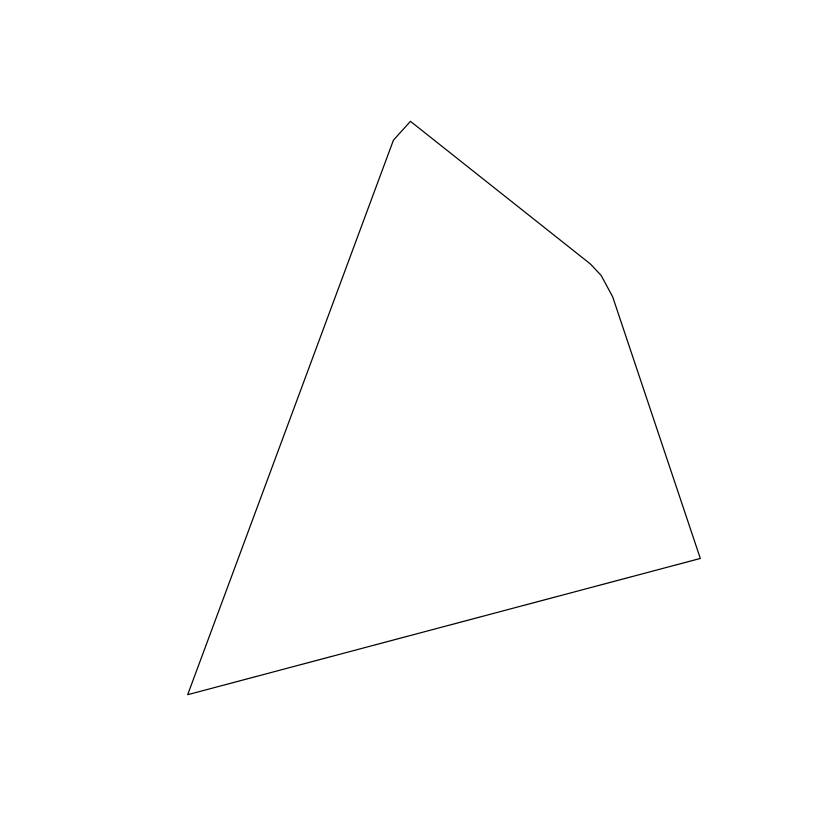

In [111]:
#Look at convex hull for fun. Calculate area in square meters.
plot(site_polygon)
area_2d<-as.numeric(st_area(site_polygon))
area_2d

In [112]:
#List Des from census data. This is NOT a correct representation of effective population densities but can be taken as an upper limit.
#Individuals per square METER
De_NC_2d<-rep(0.000067,1000)

In [113]:
#List Des from census data. This is NOT a correct representation of effective population densities but can be taken as an upper limit.
#Individuals per METER
De_NC_1d<-rep(0.32116657566325596,1000)

In [58]:
#Calculate IBD slopes (m) in one and two dimensions for each taxon. One diemnsional estimates use Cebu data only
m1<-summary(lm(Lin_FST ~ Dist_log,dat=merge1))$coefficients[2,1]
m2<-summary(lm(Lin_FST ~ Dist_log,dat=merge2))$coefficients[2,1]
m3<-summary(lm(Lin_FST ~ Dist_log,dat=merge3))$coefficients[2,1]
m4<-summary(lm(Lin_FST ~ Dist_log,dat=merge4))$coefficients[2,1]
m0<-summary(lm(Lin_FST ~ Dist_log,dat=merge0))$coefficients[2,1]

In [120]:
#Make dataframe of all slopes (for plotting). Convert m to km

ms_2d <- data.frame(
  value = c(m1s*1000, m2s*1000, m3s*1000, m4s*1000),
  group = factor(rep(c("Taxa1", "Taxa2", "Taxa3", "Taxa4"), each = 1000))
)

ms_1d <- data.frame(
  value = c(m1_Cs*1000, m2_Cs*1000, m3_Cs*1000, m4_Cs*1000),
  group = factor(rep(c("Taxa1", "Taxa2", "Taxa3", "Taxa4"), each = 1000))
)

In [121]:
#Calculate distribution of 1000 sigmas for all 2d kernels with census density
sigmas1_2d_NC<-sigmaFrom_m(De_NC_2d[1],De_NC_2d,m1,se1,dims=2)
sigmas2_2d_NC<-sigmaFrom_m(De_NC_2d[1],De_NC_2d,m2,se2,dims=2)
sigmas3_2d_NC<-sigmaFrom_m(De_NC_2d[1],De_NC_2d,m3,se3,dims=2)
sigmas4_2d_NC<-sigmaFrom_m(De_NC_2d[1],De_NC_2d,m4,se4,dims=2)

sigmas0_2d_NC<-sigmaFrom_m(De_NC_2d[1],De_NC_2d,m0,se0,dims=2)

Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * De * m)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”


In [122]:
#Calculate distribution of 1000 sigmas for all 2d kernels with census density
sigmas1_1d_NC<-sigmaFrom_m(De_NC_1d[1],De_NC_1d,m1_Ceb,se1_Ceb,dims=1)
sigmas2_1d_NC<-sigmaFrom_m(De_NC_1d[1],De_NC_1d,m2_Ceb,se2_Ceb,dims=1)
sigmas3_1d_NC<-sigmaFrom_m(De_NC_1d[1],De_NC_1d,m3_Ceb,se3_Ceb,dims=1)
sigmas4_1d_NC<-sigmaFrom_m(De_NC_1d[1],De_NC_1d,m4_Ceb,se4_Ceb,dims=1)

sigmas0_1d_NC<-sigmaFrom_m(De_NC_1d[1],De_NC_1d,m0_Ceb,se0_Ceb,dims=1)

Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * De * m)):
“NaNs produced”
Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”


In [131]:
sigmas0_2d_NC$sigma_point
sigmas0_1d_NC$sigma_point

[1] 588.7686

[1] 4378.114

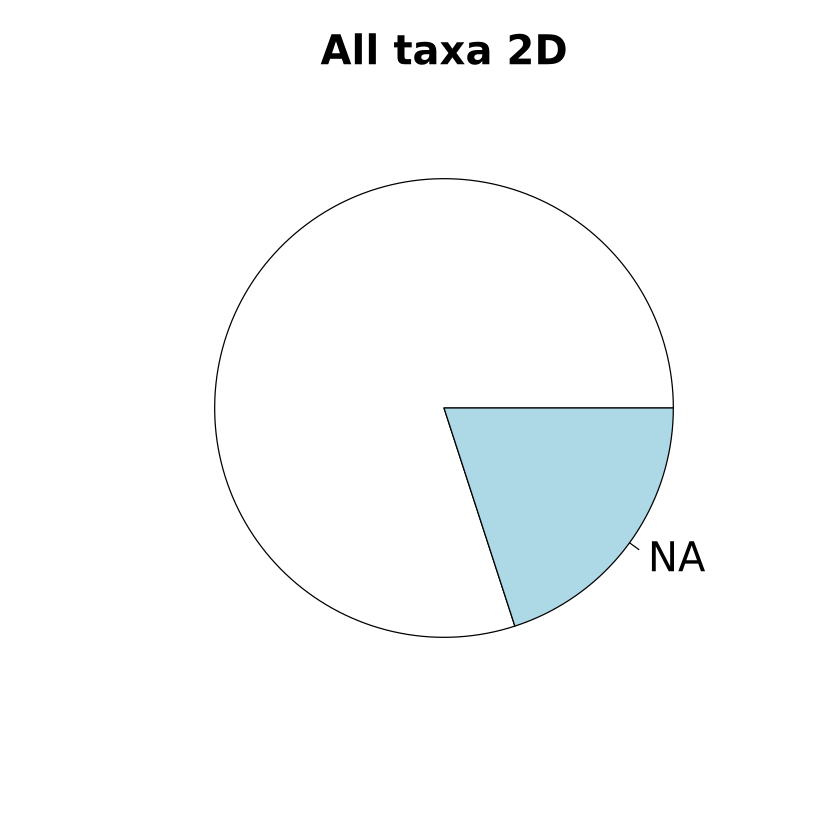

In [134]:
pie(table(is.nan(sigmas1_2d_NC$sigmas)),labels=c('','NA'),cex=2,main='All taxa 2D',cex.main=2)

In [135]:
table(is.nan(sigmas1_2d_NC$sigmas))


FALSE  TRUE 
  800   200 

In [138]:
#Look at the median of the calculated sigmas
median(na.omit(sigmas1_2d_NC$sigmas))
median(na.omit(sigmas2_2d_NC$sigmas))
median(na.omit(sigmas3_2d_NC$sigmas))
median(na.omit(sigmas4_2d_NC$sigmas))

median(na.omit(sigmas0_2d_NC$sigmas))

[1] 696.2618

[1] 1144.278

[1] 276.7817

[1] 639.6796

[1] 549.1595

In [140]:
#Look at the median of the calculated sigmas
median(na.omit(sigmas1_1d_NC$sigmas))
median(na.omit(sigmas2_1d_NC$sigmas))
median(na.omit(sigmas3_1d_NC$sigmas))
median(na.omit(sigmas4_1d_NC$sigmas))
median(na.omit(sigmas0_1d_NC$sigmas))

[1] 3584.844

[1] 5357.733

[1] 1217.034

[1] 3011.229

[1] 3458.772

`geom_smooth()` using formula = 'y ~ x'
Saving 7 x 7 in image
`geom_smooth()` using formula = 'y ~ x'


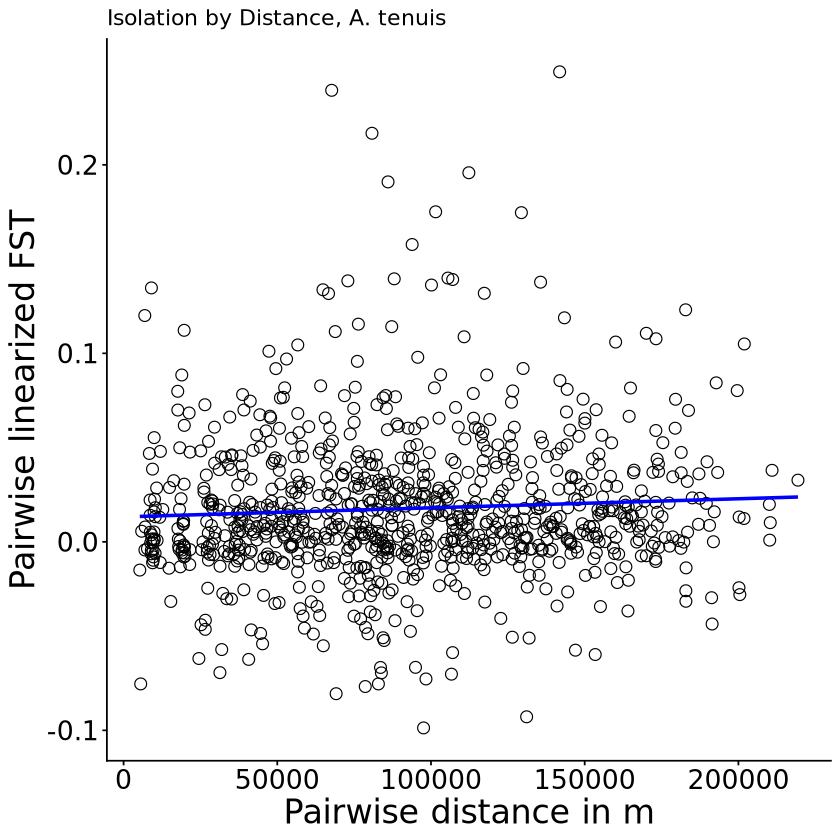

In [142]:
#Plot IBD curve of all cryptic taxa together
ggplot(merge0, aes(x=Distance_m, y=Lin_FST)) + geom_point(shape=1,size=3)+
theme_classic()+
theme(axis.text.x = element_text(size = 16),axis.text.y = element_text(size = 16),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20))+
ggtitle('Isolation by Distance, A. tenuis')+
geom_smooth(method=lm, color="blue",se=FALSE)+
labs(x="Pairwise distance in m", y = "Pairwise linearized FST")
ggsave('Acropora_IBD_all.png',dpi = 1200)

In [64]:
#Create little dataframes justfor figure plotting
figdat1<-join_for_fig(merge1,fst1_long)
figdat2<-join_for_fig(merge2,fst2_long)
figdat3<-join_for_fig(merge3,fst3_long)
figdat4<-join_for_fig(merge4,fst4_long)

In [151]:
#Not going to use this one
figdat3_special<-join_for_fig(merge3_special,fst3_long_special)

In [65]:
#Calculate confidence intervals around slopes for plotting
slope_min1<-quantile(m1s_km,probs=c(0.025))
slope_max1<-quantile(m1s_km,probs=c(0.975))
intercept1<-lm(Lin_FST ~ log(Distance_km), data = figdat1)$coefficients[1]
value_mins1<-intercept1+slope_min1*log(figdat1$Distance_km)
value_maxs1<-intercept1+slope_max1*log(figdat1$Distance_km)

slope_min2<-quantile(m2s_km,probs=c(0.025))
slope_max2<-quantile(m2s_km,probs=c(0.975))
intercept2<-lm(Lin_FST ~ log(Distance_km), data = figdat2)$coefficients[1]
value_mins2<-intercept2+slope_min2*log(figdat2$Distance_km)
value_maxs2<-intercept2+slope_max2*log(figdat2$Distance_km)

slope_min3<-quantile(m3s_km,probs=c(0.025))
slope_max3<-quantile(m3s_km,probs=c(0.975))
intercept3<-lm(Lin_FST ~ log(Distance_km), data = figdat3)$coefficients[1]
value_mins3<-intercept1+slope_min3*log(figdat3$Distance_km)
value_maxs3<-intercept1+slope_max3*log(figdat3$Distance_km)

slope_min4<-quantile(m4s_km,probs=c(0.025))
slope_max4<-quantile(m4s_km,probs=c(0.975))
intercept4<-lm(Lin_FST ~ log(Distance_km), data = figdat4)$coefficients[1]
value_mins4<-intercept4+slope_min4*log(figdat4$Distance_km)
value_maxs4<-intercept4+slope_max4*log(figdat4$Distance_km)

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


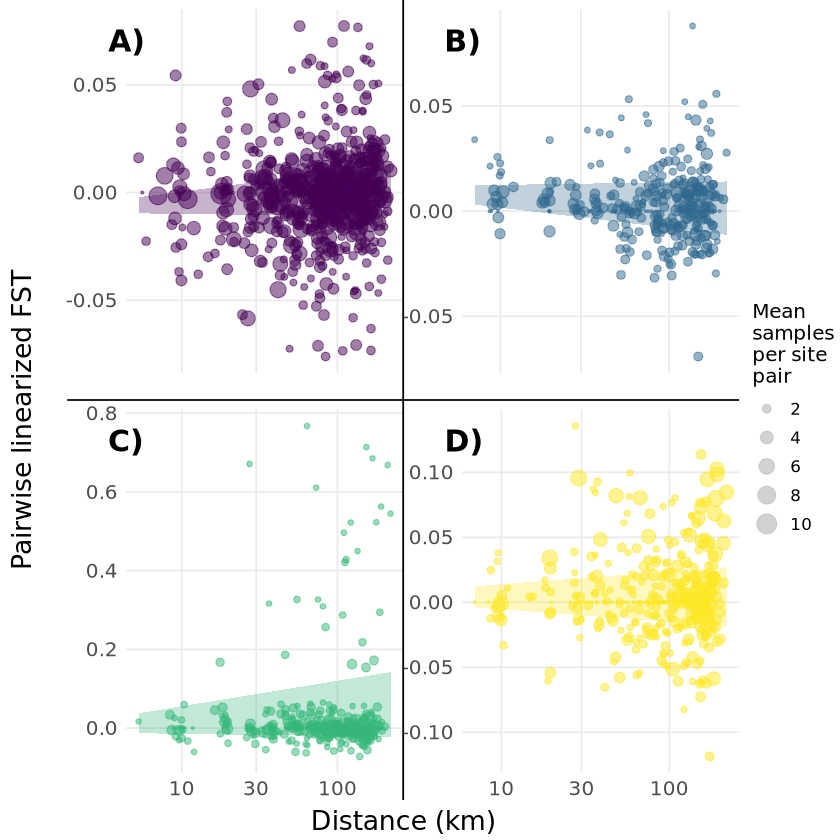

In [75]:
#Make figure of isolation in each taxon 2D
fst_plot<-function(data,color,title,ul=0.5,fsts_lin,log_dists,xlabel=NULL,ylabel=NULL,ribbon_mins,ribbon_maxs){
  pl<-ggplot(data, aes(x = as.numeric(Distance_km), y = Lin_FST)) +
  geom_point(aes(size = mean_counts), col=color, alpha=0.5) +
  geom_ribbon(aes(ymin = ribbon_mins, ymax = ribbon_maxs), fill=color, alpha = 0.3)+
  scale_size_continuous(name = "Mean samples per site pair", range = c(0.5, 0.5*max(data$mean_counts))) +
    theme_minimal() +
    scale_x_continuous(trans='log10') +
    #ylim(-0.1, ul) + 
    theme(axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.text.x = element_text(size = 12),
          axis.text.y = element_text(size = 12),  # Changed from element_blank()
          plot.margin = unit(c(0, 0, 0, 0),"cm"),
          panel.grid.minor = element_blank(),
          legend.position = "none")
  
  # Only add labels if they're not NULL - but we're not using xlabel anymore
  if (!is.null(ylabel)) {
    pl <- pl + ylab(ylabel)
  }
  
  return(pl) 
}

# Create the four plots
# Top row plots (A and B) - no x-axis labels
plot_a <- fst_plot(figdat1, "#440154FF", 'Taxa 1', ul=0.6,fsts_lin=fst_lin1,log_dists=log_dists1,ribbon_mins=value_mins1,ribbon_maxs=value_maxs1) +
  theme(axis.text.x = element_blank(),          # Remove x-axis text for top plot
        axis.ticks.x = element_blank(),         # Remove x-axis ticks for top plot
        axis.title.x = element_blank())         # Remove x-axis title for top plot

plot_b <- fst_plot(figdat2, "#31688EFF", 'Taxa 2', ul=0.6,fsts_lin=fst_lin2,log_dists=log_dists2,ribbon_mins=value_mins2,ribbon_maxs=value_maxs2) +
  theme(axis.text.x = element_blank(),          # Remove x-axis text for top plot
        axis.ticks.x = element_blank(),         # Remove x-axis ticks for top plot
        axis.title.x = element_blank())         # Remove x-axis title for top plot

# Bottom row plots (C and D)
plot_c <- fst_plot(figdat3, "#35B779FF", 'Taxa 3', ul=0.6,fsts_lin=fst_lin3,log_dists=log_dists3,ribbon_mins=value_mins3,ribbon_maxs=value_maxs3) +
  coord_cartesian(clip = "off") +
  theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))  # Add small top margin

plot_d <- fst_plot(figdat4, "#FDE725FF", 'Taxa 4', ul=0.6,fsts_lin=fst_lin4,log_dists=log_dists4,ribbon_mins=value_mins4,ribbon_maxs=value_maxs4)

# Combine plots using cowplot with no spacing
combined_plot <- plot_grid(
  plot_a, plot_b,
  plot_c, plot_d,
  ncol = 2, 
  nrow = 2,
  labels = c("A)", "B)", "C)", "D)"),
  label_size = 18,
  label_colour = "black",
  label_x = 0.1,  # Position labels in top left corner
  label_y = 0.86,
  align = "hv",    # Align both horizontally and vertically
  rel_widths = c(1, 1),  # Equal width for columns
  rel_heights = c(1, 1), # Equal height for rows
  hjust = -0.2,       # Remove horizontal spacing
  vjust = -0.2        # Remove vertical spacing
)

# Add dividing lines between panels
combined_plot_with_lines <- ggdraw(combined_plot) +
  # Vertical line down the middle
  draw_line(x = c(0.5, 0.5), y = c(0, 1), color = "black", linewidth = 0.5) +
  # Horizontal line across the middle
  draw_line(x = c(0, 1), y = c(0.5, 0.5), color = "black", linewidth = 0.5)

# Create a shared x-axis label for the bottom
x_axis_label <- ggdraw() + 
  draw_label("Distance (km)", 
             x = 0.5, y = 0.5, 
             size = 16,
             hjust = 0.5)

# Combine the plots with the shared x-axis label first
plot_with_xlabel <- plot_grid(
  combined_plot_with_lines,
  x_axis_label,
  ncol = 1,
  rel_heights = c(1, 0.05)  # Most space for plots, small space for x-label
)

# Create a sample plot just to extract the legend (using gray points)
legend_plot <- ggplot(figdat1, aes(x = as.numeric(Distance_m), y = Lin_FST, size = mean_counts)) +
  geom_point(col="gray", alpha = 0.7) +
  scale_size_continuous(name = "Mean \nsamples\nper site \npair", 
                       range = c(0.5, 0.5*max(figdat1$mean_counts)),
                       breaks = pretty(figdat1$mean_counts, n = 4)) +
  theme_minimal() +
  theme(legend.position = "right",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10))

# Extract just the legend
legend <- get_legend(legend_plot)

# Add the legend to the right side
plot_with_all_elements <- plot_grid(
  plot_with_xlabel,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.15)  # Most space for plots, small space for legend
)

# Add shared y-axis label with better positioning
final_plot <- ggdraw() +
  # Add the main plot content with offset from left
  draw_plot(plot_with_all_elements, x = 0.08, y = 0, width = 0.92, height = 1) +
  # Add y-axis label in the left margin space
  draw_label("Pairwise linearized FST", 
             x = 0.025, y = 0.5,  
             angle = 90, 
             size = 16,
             hjust = 0.5)

# Display the combined plot
print(final_plot)

# Save the plot
ggsave("combined_ibd_plot.jpg", final_plot, width = 7, height = 5, dpi = 800)

In [81]:
rm(final_plot)

In [155]:
#Prepare data for additonal plot
merge1$taxon<-"Taxa1"
merge2$taxon<-"Taxa2"
merge3$taxon<-"Taxa3"
merge4$taxon<-"Taxa4"

In [156]:
#Prepare data for additonal plot
all_taxa<-full_join(merge1,merge2)
all_taxa<-full_join(all_taxa,merge3)
all_taxa<-full_join(all_taxa,merge4)
all_taxa$taxon<-as.factor(all_taxa$taxon)
colnames(all_taxa)

Joining with `by = join_by(SiteA, SiteB, Lin_FST, Distance_m, Dist_log,
Dist_log_km, taxon)`
Joining with `by = join_by(SiteA, SiteB, Lin_FST, Distance_m, Dist_log,
Dist_log_km, taxon)`
Joining with `by = join_by(SiteA, SiteB, Lin_FST, Distance_m, Dist_log,
Dist_log_km, taxon)`


[1] "SiteA"       "SiteB"       "Lin_FST"     "Distance_m"  "Dist_log"   
[6] "Dist_log_km" "taxon"

`geom_smooth()` using formula = 'y ~ x'


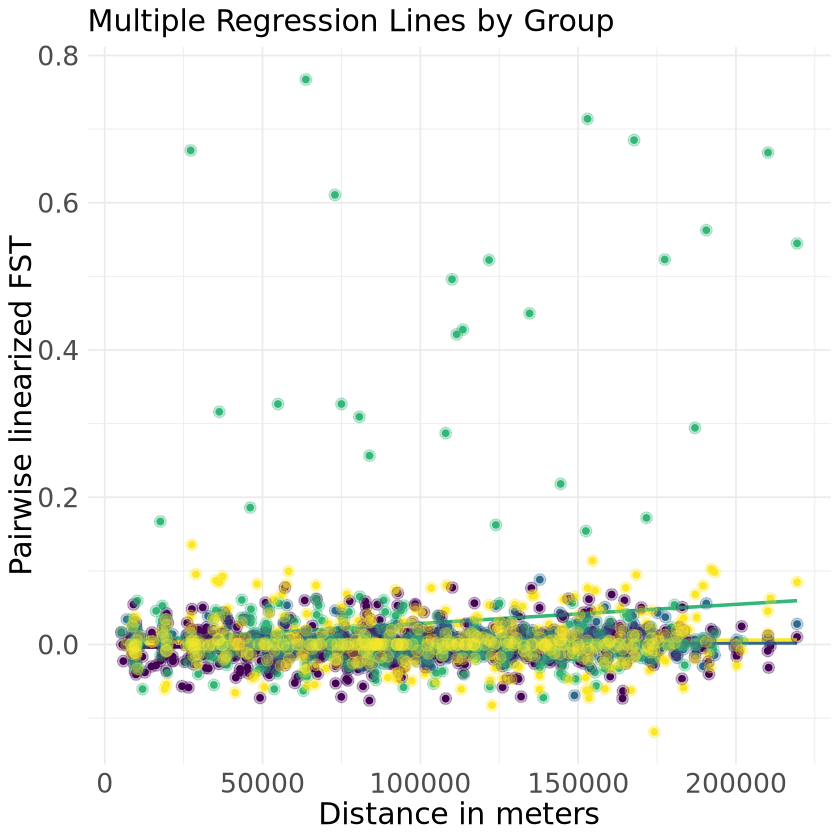

In [158]:
#Wow that's an ugly plot that no one can be reasonably expected to interpret. Let's not save it
plot_colors <- c("Taxa1"="#440154FF", "Taxa2"="#31688EFF", "Taxa3"="#35B779FF", "Taxa4"="#FDE725FF")

ggplot(all_taxa, aes(x = Distance_m, y = Lin_FST, color = taxon)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Multiple Regression Lines by Group",
       x = "Distance in meters",
       y = "Pairwise linearized FST",
       color = "Group") +
  scale_color_manual(values = plot_colors) +
  theme_minimal() +
geom_point(size = 3,alpha = 0.3) +
  theme(plot.title = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.text.x = element_text(size = 16),
        axis.title.y = element_text(size = 18),
        axis.text.y = element_text(size = 16),
        legend.position = "none")
